In [1]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from torchvision.models import resnet18
import zipfile
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [3]:
print(torch.cuda.device_count())

1


In [4]:
augs = T.Compose([
    T.RandomRotation(degrees = 20),
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_augs=  T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [5]:
img_files = os.listdir('data/train/train')

def train_path(p):
    return f"data/train/train/{p}"

img_files = list(map(train_path, img_files))
random.shuffle(img_files)

train = img_files[:20000]
val = img_files[20000:]

for i in range(100):
    print(train[i])

class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

data/train/train/cat.9362.jpg
data/train/train/dog.1615.jpg
data/train/train/cat.9045.jpg
data/train/train/cat.6493.jpg
data/train/train/dog.5705.jpg
data/train/train/dog.809.jpg
data/train/train/cat.6504.jpg
data/train/train/cat.8305.jpg
data/train/train/cat.1346.jpg
data/train/train/cat.9758.jpg
data/train/train/dog.1575.jpg
data/train/train/dog.4509.jpg
data/train/train/cat.1165.jpg
data/train/train/cat.556.jpg
data/train/train/dog.1828.jpg
data/train/train/dog.11370.jpg
data/train/train/cat.10173.jpg
data/train/train/cat.11722.jpg
data/train/train/cat.1194.jpg
data/train/train/dog.9275.jpg
data/train/train/dog.617.jpg
data/train/train/cat.4959.jpg
data/train/train/dog.4395.jpg
data/train/train/cat.11951.jpg
data/train/train/dog.4182.jpg
data/train/train/dog.12316.jpg
data/train/train/dog.3419.jpg
data/train/train/cat.1739.jpg
data/train/train/cat.7726.jpg
data/train/train/cat.145.jpg
data/train/train/dog.934.jpg
data/train/train/cat.7773.jpg
data/train/train/dog.6372.jpg
data/train

In [6]:
train_data = CatDogDataset(train, augs)
val_data = CatDogDataset(val, test_augs)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)


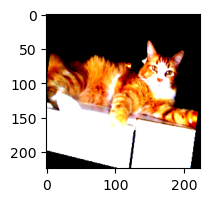

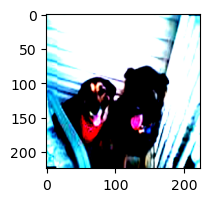

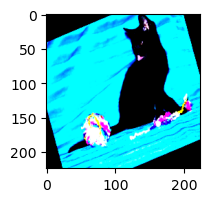

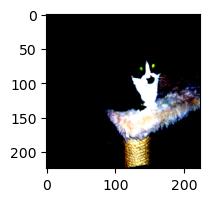

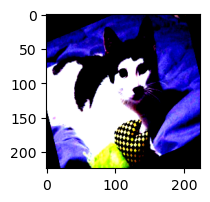

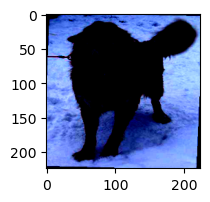

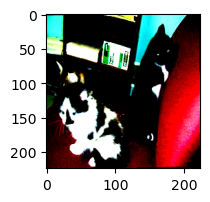

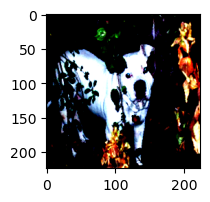

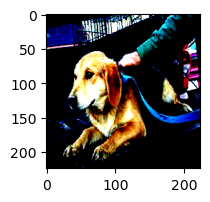

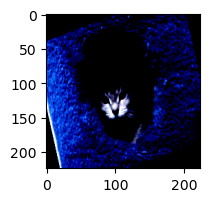

In [7]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    print(labels[i])
    imshow(torchvision.utils.make_grid(images[i]))

In [8]:
def ResNet18(num_classes =2):
    model = resnet18(weights = 'IMAGENET1K_V1')
    # for params in model.parameters():
    #     params.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features,512, bias = True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,num_classes),
        nn.Softmax(-1)
    )
    return model

model = ResNet18()
model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.0001, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 200

In [10]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0 # Patience for LR scheduler
curr_epoch = 0
curr_loss = 0
best_test_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 15:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    val_acc = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            val_acc += accuracy.item()

        val_acc /= len(val_loader)
        val_loss /= len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if val_acc > best_test_acc:
            best_epoch = epoch
            best_test_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    scheduler.step(val_loss)

    if abs(val_loss - curr_loss) < 0.005 or val_loss > curr_loss:
        es_count += 1
        curr_loss = val_loss
    else:
        es_count = 0
        curr_loss = val_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {val_acc:.4f}")


Epoch 1/200 - Training Acc: 0.7459 - Validation Acc: 0.9389
Epoch 2/200 - Training Acc: 0.9211 - Validation Acc: 0.9628
Epoch 3/200 - Training Acc: 0.9469 - Validation Acc: 0.9678
Epoch 4/200 - Training Acc: 0.9562 - Validation Acc: 0.9747
Epoch 5/200 - Training Acc: 0.9602 - Validation Acc: 0.9796
Epoch 6/200 - Training Acc: 0.9672 - Validation Acc: 0.9784
Epoch 7/200 - Training Acc: 0.9685 - Validation Acc: 0.9782
Epoch 8/200 - Training Acc: 0.9694 - Validation Acc: 0.9786
Epoch 9/200 - Training Acc: 0.9702 - Validation Acc: 0.9832
Epoch 10/200 - Training Acc: 0.9716 - Validation Acc: 0.9826
Epoch 11/200 - Training Acc: 0.9724 - Validation Acc: 0.9836
Epoch 12/200 - Training Acc: 0.9737 - Validation Acc: 0.9852
Epoch 13/200 - Training Acc: 0.9737 - Validation Acc: 0.9844
Epoch 14/200 - Training Acc: 0.9732 - Validation Acc: 0.9846
Epoch 15/200 - Training Acc: 0.9769 - Validation Acc: 0.9844
Epoch 16/200 - Training Acc: 0.9745 - Validation Acc: 0.9858
Epoch 17/200 - Training Acc: 0.97

In [11]:

train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
train_acc_list = np.array(train_acc_list)
val_acc_list = np.array(val_acc_list)

writer = SummaryWriter()

best_model = ResNet18()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.to(device)

writer.flush()
for i in range(curr_epoch):
    writer.add_scalars('Loss', {'Train': train_loss_list[i], 'Test': val_loss_list[i]}, i)
    writer.add_scalars('Accuracy', {'Train': train_acc_list[i], 'Test': val_acc_list[i]}, i)

writer.close()
